# Write-up and code for Feb 15

## To Do:
- ~~Prove the Epsilon-Greedy Policy Improvement Theorem (we sketched the proof in Class)~~
- ~~Provide (with clear mathematical notation) the defintion of GLIE (Greedy in the Limit with Infinite Exploration)~~
- ~~Implement the tabular SARSA and tabular SARSA(Lambda) algorithms~~
- ~~Implement the tabular Q-Learning algorithm~~
- ~~Test the above algorithms on some example MDPs by using DP Policy Iteration/Value Iteration solutions as a benchmark~~

## $\epsilon$-Greedy Policy Improvement Theorem
__Theorem:__ For any $\epsilon$-greedy policy $\pi$, the $\epsilon$-greedy policy $\pi'$ with respect to $q_\pi$ is an improvement, $v_{\pi'}(s) \geq v_\pi(s)$

__Proof:__ 
$$
\begin{align}
q_\pi(s,\pi'(s)) & = \sum_{a\in\mathcal A}\pi'(a|s)q_\pi(s,a)\\
& = \epsilon/m\sum_{a\in\mathcal A}q_\pi(s,a) + (1-\epsilon) \max_{a \in\mathcal A}q_\pi(s,a)\\
& \geq \epsilon/m\sum_{a\in\mathcal A}q_\pi(s,a) + (1-\epsilon) \sum_{a \in\mathcal A}\frac{\pi(a|s) - \epsilon/m}{1-\epsilon}q_\pi(s,a)\\
& = \sum_{a\in\mathcal A}\pi(a|s)q_\pi(s,a)\\
& = v_\pi(s)
\end{align}
$$

Therefore, from policy improvement theorem $v_{\pi'}(s) \geq v_\pi(s)$.

## Greedy in the Limit with Infinite Exploration
__Definition:__ Greedy in the Limit with Infinite Exploration (GLIE)
- All State-Action pairs are explored infinitely many times,

$$
\lim_{k\to\infty}N_k(s,a) = \infty
$$

where $N_k(s,a)$ is the number of times we have taken action $a$ and visited state $s$ after $k$ time-steps

- The policy converges on a greedy policy,

$$
\lim_{k\to\infty}\pi(a|s) = \mathbf 1\big(a=\arg\max_{a'\in\mathcal A}Q_k(s,a')\big)
$$

## Sarsa and Sarsa($\lambda$) Algorithms

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [222]:
from typing import Dict
from modules.MDP import MDP, Q, Policy, V
from modules.RL_interface import RL_interface
from modules.state_action_vars import S, A
import random

def sarsa(mdp: MDP, num_epi: int, num_steps: int, eps: float, alpha: float) -> Q:
    # implementation of Sarsa-learning
    
    # initialize Q(s,a) to zero for all state-action pairs
    q = {s: {a: 0. for a in mdp.Actions} for s in mdp.States}
    
    for i in range(num_epi):
        # sample a random starting state and an action
        s = random.sample(mdp.States,1).pop()
        if random.random() > eps:
            _, a = find_max_q(q, s)
        else:
            a = random.sample(mdp.Actions,1).pop()
        
        for j in range(num_steps):
            # observe a reward r and a next state sp
            sp, r = RL_interface(mdp, s, a)
        
            # follow an epsilon-greedy policy
            if random.random() > eps:
                _, ap = find_max_q(q, sp)
            else:
                ap = random.sample(mdp.Actions,1).pop()
            
            # update the q-function
            q[s][a] += alpha*(r + mdp.gamma*q[sp][ap] - q[s][a])
            
            s = sp
            a = ap
    return q

In [3]:
def sarsa_lambda(mdp: MDP, num_epi: int, num_steps: int, eps: float, alpha: float, lambd: float) -> Q:
    # implementation of the Sarsa-lambda algorithm
    
    # initialize Q(s,a) and N(s,a) to zero for all state-action pairs
    q = {s: {a: 0. for a in mdp.Actions} for s in mdp.States}
    n = {s: {a: 0 for a in mdp.Actions} for s in mdp.States}
    
    for i in range(num_epi):
        # sample a random starting state and an action
        s = random.sample(mdp.States,1).pop()
        if random.random() > eps:
            _, a = find_max_q(q, s)
        else:
            a = random.sample(mdp.Actions,1).pop()
        
        for j in range(num_steps):
            # observe a reward r and a next state sp
            sp, r = RL_interface(mdp, s, a)
            # follow an epsilon-greedy policy
            if random.random() > eps:
                _, ap = find_max_q(q, sp)
            else:
                ap = random.sample(mdp.Actions,1).pop()
            # increment the eligibility trace
            n[s][a] += 1
            # calculate the error
            delta = r + mdp.gamma*q[sp][ap] - q[s][a]
            
            for s_ in mdp.States:
                for a_ in mdp.Actions:
                    # update the q-function
                    q[s_][a_] += alpha*delta*n[s_][a_]
                    n[s_][a_] *= mdp.gamma*lambd
            
            s = sp
            a = ap
    return q

In [74]:
def find_max_q(q: Q, s: S) -> A:
    # returns the best action for a specific state
    best_value = -1e7
    best_a = None
    
    # loop over all the actions and store Q(s,a) and a if it is the current best action
    for a in q[s].keys():
        if q[s][a] > best_value:
            best_value = q[s][a]
            best_a = a
            
    return best_value, best_a

## Q-learning

In [90]:
def q_learning(mdp: MDP, num_epi: int, num_steps: int, eps: float, alpha: float) -> Q:
    # implementation of Sarsa-learning
    
    # initialize Q(s,a) to zero for all state-action pairs
    q = {s: {a: 0. for a in mdp.Actions} for s in mdp.States}
    
    for i in range(num_epi):
        # sample a random starting state and an action
        s = random.sample(mdp.States,1).pop()
        
        for j in range(num_steps):
            if random.random() > eps:
                _, a = find_max_q(q, s)
            else:
                a = random.sample(mdp.Actions,1).pop()
            # observe a reward r and a next state sp
            sp, r = RL_interface(mdp, s, a)
            # find the max for next state
            q_max,_ = find_max_q(q, sp)
            # update the q-function
            q[s][a] += alpha*(r + mdp.gamma*q_max - q[s][a])
            
            s = sp
    return q

In [6]:
def q_to_policy(q: Q) -> Policy:
    # takes in Q(s,a) and returns a greedy policy
    policy = {s: {a: 0.0 for a in q[s]} for s in q}
    
    for s in q:
        _, a = find_max_q(q, s)
        policy[s][a] = 1.0
    
    return policy

In [224]:
def q_to_v(q: Q) -> V:
    # takes in Q(s,a) and returns the value function for the optimal policy
    vf = {s: 0.0 for s in q}
    
    for s in q:
        q_max, _ = find_max_q(q, s)
        vf[s] = q_max
    
    return vf

## Gridworld Example
Continue on the previous Gridworld example. Remember, there are positive rewards of entering state (0,0) and (3,3) while there is a negative reward when entering state (1,2).

In [7]:
from modules.gridworld import gridworld
import numpy as np
gw = gridworld(0.9)

In [8]:
def print_policy_gridworld(policy: Policy):
    # function that prints out the grid
    last_s = (0,0)
    for s in sorted(policy.keys()):
        if s[0] != last_s[0]:
            print()
        for a in policy[s]:
            
            if np.abs(policy[s][a] - 1.0) < 1e-6:
                if a == 1:
                    string = '<-'
                elif a == 2:
                    string = '->'
                elif a == 3:
                    string = '/\\'
                else:
                    string = '\\/'
                print(s, ": {} \t".format(string), end='')
        last_s = s
    print('\n')

In [47]:
q_sarsa = sarsa(gw, 1000, 30, 0.3, 0.01)
q_sarsa_lambda = sarsa_lambda(gw, 10000, 30, 0.3, 0.01, 0.9)
#q_learn = q_learning(gw, 1000, 30, 0.3, 0.01)

In [48]:
policy_sarsa = q_to_policy(q_sarsa)
policy_sarsa_lambda = q_to_policy(q_sarsa_lambda)
#policy_qlearn = q_to_policy(q_learn)

In [49]:
print_policy_gridworld(policy_sarsa)
print_policy_gridworld(policy_sarsa_lambda)
#print_policy_gridworld(policy_qlearn)

(0, 0) : <- 	(0, 1) : <- 	(0, 2) : <- 	(0, 3) : <- 	
(1, 0) : /\ 	(1, 1) : <- 	(1, 2) : <- 	(1, 3) : \/ 	
(2, 0) : /\ 	(2, 1) : <- 	(2, 2) : \/ 	(2, 3) : <- 	
(3, 0) : /\ 	(3, 1) : -> 	(3, 2) : -> 	(3, 3) : <- 	

(0, 0) : /\ 	(0, 1) : <- 	(0, 2) : <- 	(0, 3) : <- 	
(1, 0) : /\ 	(1, 1) : <- 	(1, 2) : <- 	(1, 3) : \/ 	
(2, 0) : /\ 	(2, 1) : \/ 	(2, 2) : -> 	(2, 3) : \/ 	
(3, 0) : /\ 	(3, 1) : -> 	(3, 2) : -> 	(3, 3) : -> 	



## Example Jack's Car Rental
The number of cars available in the afternoon at $t+1$ in location A is given by:

$$
A_{t+1} = A_t + N^A_{t+1} - M^A_{t+1} + D_t
$$

where $N^A_t$ is the number of cars returned to A, $M^A_t$ is the number of cars rented at A, and $D_t$ is the number of cars moved between A and B. A negative number for $D_t$ means we move cars from A to B, a positive number means we move cars from B to A. The equation is similar for location B,

$$
B_{t+1} = B_t + N^B_{t+1} - M^B_{t+1} - D_t
$$

Given that we know the distribution we can find an analytical answer to the transition probabilities. However, my ability to derive those probabilities is limited and I will hence rely on simulations to approximate the transitions probabilities.

In [387]:
def state_simulator(s: S, a: A, mu_A_rent: float, mu_A_return: float, mu_B_rent: float, mu_B_return: float) -> S:
    # function that takes in a state and an action (and Poisson parameters), and returns next states S'
    # assume s is a tuple of (S_A, S_B), where S_A and S_B is the number of cars at A and B respectively
    
    # assume that we first move cars, then we rent out cars, and finally we have cars returned
    # simulate number of rentals at A, we cannot rent out more cars than what we have
    M_A = np.minimum(np.random.poisson(lam=mu_A_rent), s[0] + a)
    # simulate number of returns to A
    N_A = np.random.poisson(lam=mu_A_return)
    # simulate number of rentals at B
    M_B = np.minimum(np.random.poisson(lam=mu_B_rent), s[1] - a)
    # simulate number of returns to B
    N_B = np.random.poisson(lam=mu_B_return)
    
    # make sure we don't have more than 20 cars at A/B, or less than 0
    S_A = np.minimum(20, s[0] + N_A - M_A + a)
    S_B = np.minimum(20, s[1] + N_B - M_B - a)
    S_next = (S_A, S_B)
    r = -2.0*np.abs(a) + 10.0*(M_A + M_B)
    
    return S_next, r

In [64]:
States = set()
Actions = set()
for i in range(21):
    for j in range(21):
        States.add((i,j))

for a in range(-5, 6, 1):
    Actions.add(a)

Calculate the transition probabilities and the expected rewards using the Poisson distributions. The difference between two Poisson random variables follow a Skellam distribution.

In [366]:
from scipy.stats import poisson, skellam

def trans_prob_rew(s: S, a: A, sp: S) -> float:
    # given a state s, an action a, and a new state sp, the function returns the probability of that transition
    # assumes poisson distributed rentals and returns
    
    # find the number of returns - rentals we had for this transition to be possible at A
    diff_A = sp[0] - s[0] - a
    # find the difference in number of cars at B
    diff_B = sp[1] - s[1] + a
    # the difference between two Poisson r.v.'s follows a Skellam distribution
    p_A = skellam.pmf(diff_A, mu1=3, mu2=3)
    p_B = skellam.pmf(diff_B, mu1=2, mu2=4)
    
    return p_A*p_B

In [368]:
P = {}
R = {}
i = 0
for s in States:
    P[s] = {}
    R[s] = {}
    for a in Actions:
        if (a <= 0 and np.abs(a) <= s[0]) or (a > 0 and a <= s[1]):
            P[s][a] = {}
            R[s][a] = -2*np.abs(a) + 10*(np.minimum(s[0] + a, 3) + np.minimum(s[1] - a, 4))
            for sp in States:
                P[s][a][sp] = transition_prob(s, a, sp)
    i += 1
    if i % 50 == 0: print(i/len(States))

0.11337868480725624
0.22675736961451248
0.3401360544217687
0.45351473922902497
0.5668934240362812
0.6802721088435374
0.7936507936507936
0.9070294784580499


Define the MDP for this problem

In [369]:
mdp_jack = MDP(States, P, Actions, R, 0.9)

In [373]:
from modules.DP import value_iter
vf_jack = value_iter(mdp_jack, 1e-5)

In [380]:
from modules.DP import policy_iter

# define a start policy that never moves any cars
policy_jack = {}
for s in States:
    policy_jack[s] = {}
    for a in Actions:
        if (a <= 0 and np.abs(a) <= s[0]) or (a > 0 and a <= s[1]):
            policy_jack[s][a] = 0.0
    policy_jack[s][0] = 1.0

policy_jack = policy_iter(mdp_jack, policy_jack, 1e-5)

The combined state-action space is too large to estimate. Hence we feed in the simulator into our Q-learning algorithm, however we need to cahge the algorithm slightly for this to work.

In [393]:
from typing import Callable, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

def q_learning_jack(States: Set[S], Actions: Set[A], num_epi: int, 
                    num_steps: int, eps: float, alpha: float, gamma: float) -> Q:
    # implementation of Sarsa-learning
    
    # initialize Q(s,a) to zero for all state-action pairs
    q = {}
    for s in States:
        q[s] = {}
        for a in Actions:
            if (a <= 0 and np.abs(a) <= s[0]) or (a > 0 and a <= s[1]):
                q[s][a] = 0.0
                
    for i in range(num_epi):
        # sample a random starting state and an action
        s = random.sample(States,1).pop()
        
        for j in range(num_steps):
            if random.random() > eps:
                _, a = find_max_q(q, s)
            else:
                a = random.sample(list(q[s]),1).pop()
            # observe a reward r and a next state sp
            sp, r = state_simulator(s, a, 3, 3, 4, 2)
            # find the max for next state
            
            q_max, _ = find_max_q(q, sp)
            # update the q-function
            q[s][a] += alpha*(r + gamma*q_max - q[s][a])
            
            s = sp

    return q

In [392]:
def sarsa_jack(States: Set[S], Actions: Set[A], num_epi: int, 
                    num_steps: int, eps: float, alpha: float, gamma: float) -> Q:
    # implementation of Sarsa-learning
    
    # initialize Q(s,a) to zero for all state-action pairs
    q = {}
    for s in States:
        q[s] = {}
        for a in Actions:
            if (a <= 0 and np.abs(a) <= s[0]) or (a > 0 and a <= s[1]):
                q[s][a] = 0.0
                
    for i in range(num_epi):
        # sample a random starting state and an action
        s = random.sample(States,1).pop()
        
        # follow an epsilon-greedy policy
        if random.random() > eps:
            _, a = find_max_q(q, s)
        else:
            a = random.sample(list(q[s]),1).pop()
        
        for j in range(num_steps):
            # observe a reward r and a next state sp
            sp, r = state_simulator(s, a, 3, 3, 4, 2)
            
            # find the action for the next state
            if random.random() > eps:
                _, ap = find_max_q(q, sp)
            else:
                ap = random.sample(list(q[sp]),1).pop()
            
            # update the q-function
            q[s][a] += alpha*(r + gamma*q[sp][ap] - q[s][a])
            
            s = sp
            a = ap

    return q

In [394]:
q_jack_ql = q_learning_jack(States, Actions, 10000, 100, 0.8, 0.001, 0.9)

In [395]:
q_jack_sarsa = sarsa_jack(States, Actions, 10000, 100, 0.8, 0.001, 0.9)

In [396]:
q_policy_jack_ql = q_to_policy(q_jack_ql)
vf_jack_ql = q_to_v(q_jack_ql)

q_policy_jack_sarsa = q_to_policy(q_jack_sarsa)
vf_jack_sarsa = q_to_v(q_jack_sarsa)

In [397]:
policy_grid_jack = np.zeros((21,21))
value_grid_jack = np.zeros((21,21))

policy_grid_ql = np.zeros((21,21))
value_grid_ql = np.zeros((21,21))

policy_grid_sarsa = np.zeros((21,21))
value_grid_sarsa = np.zeros((21,21))

for s in q_policy_jack_ql:
    value_grid_ql[s[1], s[0]] = vf_jack_ql[s]
    value_grid_sarsa[s[1], s[0]] = vf_jack_sarsa[s]
    value_grid_jack[s[1], s[0]] = vf_jack[s]
    for a in q_policy_jack_ql[s]:
        if np.abs(q_policy_jack_ql[s][a] - 1.0) < 1e-6:
            # swap x and y for comparability with sutton
            policy_grid_ql[s[1],s[0]] = a
        if np.abs(q_policy_jack_sarsa[s][a] - 1.0) < 1e-6:
            # swap x and y for comparability with sutton
            policy_grid_sarsa[s[1],s[0]] = a
        if np.abs(policy_jack[s][a] - 1.0) < 1e-6:
            # swap x and y for comparability with sutton
            policy_grid_jack[s[1],s[0]] = a

## Q-learning

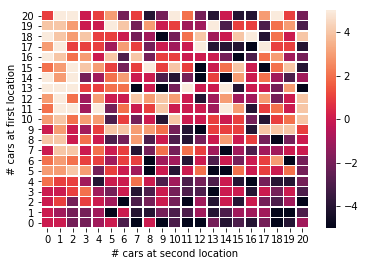

In [398]:
ax = sns.heatmap(policy_grid_ql, linewidth=0.5)
ax.invert_yaxis()
plt.ylabel('# cars at first location')
plt.xlabel('# cars at second location')
plt.show()

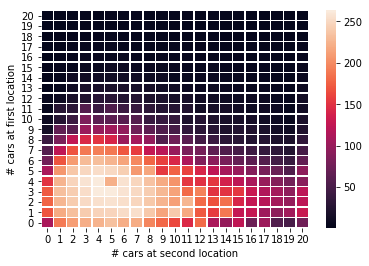

In [399]:
ax = sns.heatmap(value_grid, linewidth=0.5)
ax.invert_yaxis()
plt.ylabel('# cars at first location')
plt.xlabel('# cars at second location')
plt.show()

## Sarsa

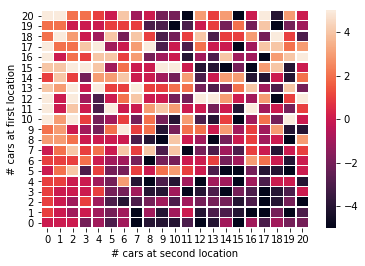

In [400]:
ax = sns.heatmap(policy_grid_sarsa, linewidth=0.5)
ax.invert_yaxis()
plt.ylabel('# cars at first location')
plt.xlabel('# cars at second location')
plt.show()

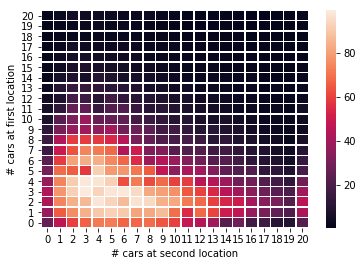

In [401]:
ax = sns.heatmap(value_grid_sarsa, linewidth=0.5)
ax.invert_yaxis()
plt.ylabel('# cars at first location')
plt.xlabel('# cars at second location')
plt.show()

In [328]:
s0 = 10, 10
a0 = -2
mu_A_rent, mu_A_return, mu_B_rent, mu_B_return = 3, 3, 4, 2

In [332]:
s1, r = state_simulator(s0, a0, mu_A_rent, mu_A_return, mu_B_rent, mu_B_return)
for i in range(20):
    s1, r = state_simulator(s1, a0, mu_A_rent, mu_A_return, mu_B_rent, mu_B_return)
    print(s1, r)

(2, 11) 56.0
(4, 13) 26.0
(4, 15) 26.0
(2, 20) 36.0
(4, 19) 26.0
(3, 20) 56.0
(0, 19) 56.0
(2, 16) 26.0
(1, 11) 86.0
(2, 14) 16.0
(3, 9) 76.0
(5, 10) 26.0
(1, 9) 76.0
(5, 12) 16.0
(4, 13) 36.0
(7, 7) 106.0
(0, 6) 96.0
(2, 10) -4.0
(2, 14) 16.0
(3, 14) 36.0


## Value iteration

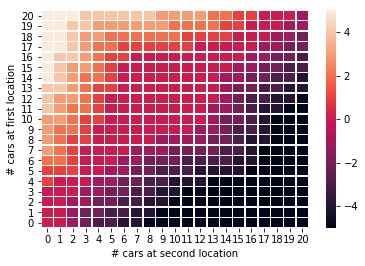

In [384]:
ax = sns.heatmap(policy_grid_jack, linewidth=0.5)
ax.invert_yaxis()
plt.ylabel('# cars at first location')
plt.xlabel('# cars at second location')
plt.show()

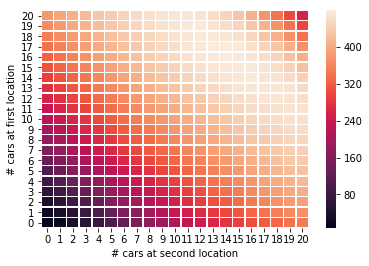

In [383]:
ax = sns.heatmap(value_grid_jack, linewidth=0.5)
ax.invert_yaxis()
plt.ylabel('# cars at first location')
plt.xlabel('# cars at second location')
plt.show()